In [1]:
import torch 
import torch.nn as nn 
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizerFast #, TFDistilBertModel
from transformers import TFDistilBertForTokenClassification
from tqdm import tqdm_notebook as tqdm

In [2]:
import numpy as np

def get_angles(pos, i, d):
    """
    Get the angles for the positional encoding
    
    Arguments:
        pos -- Column vector containing the positions [[0], [1], ...,[N-1]]
        i --   Row vector containing the dimension span [[0, 1, 2, ..., M-1]]
        d(integer) -- Encoding size
    
    Returns:
        angles -- (pos, d) numpy array 
    """
    # START CODE HERE
    angles = pos/ (np.power(10000, (2 * (i//2)) / np.float32(d)))
    # END CODE HERE
    
    return angles

In [3]:
# UNIT TEST
def get_angles_test(target):
    position = 4
    d_model = 16
    pos_m = np.arange(position)[:, np.newaxis]
    dims = np.arange(d_model)[np.newaxis, :]

    result = target(pos_m, dims, d_model)

    assert type(result) == np.ndarray, "You must return a numpy ndarray"
    assert result.shape == (position, d_model), f"Wrong shape. We expected: ({position}, {d_model})"
    assert np.sum(result[0, :]) == 0
    assert np.isclose(np.sum(result[:, 0]), position * (position - 1) / 2)
    even_cols =  result[:, 0::2]
    odd_cols = result[:,  1::2]
    assert np.all(even_cols == odd_cols), "Submatrices of odd and even columns must be equal"
    limit = (position - 1) / np.power(10000,14.0/16.0)
    assert np.isclose(result[position - 1, d_model -1], limit ), f"Last value must be {limit}"

    print("\033[92mAll tests passed")

get_angles_test(get_angles)

# Example
position = 4
d_model = 8
pos_m = np.arange(position)[:, np.newaxis]
dims = np.arange(d_model)[np.newaxis, :]
get_angles(pos_m, dims, d_model)

All tests passed


array([[0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00],
       [1.e+00, 1.e+00, 1.e-01, 1.e-01, 1.e-02, 1.e-02, 1.e-03, 1.e-03],
       [2.e+00, 2.e+00, 2.e-01, 2.e-01, 2.e-02, 2.e-02, 2.e-03, 2.e-03],
       [3.e+00, 3.e+00, 3.e-01, 3.e-01, 3.e-02, 3.e-02, 3.e-03, 3.e-03]])

In [4]:
def positional_encoding(positions, d):
    """
    Precomputes a matrix with all the positional encodings 
    
    Arguments:
        positions (int) -- Maximum number of positions to be encoded 
        d (int) -- Encoding size 
    
    Returns:
        pos_encoding -- (1, position, d_model) A matrix with the positional encodings
    """
    # START CODE HERE
    # initialize a matrix angle_rads of all the angles 
    angle_rads = get_angles(np.arange(positions)[:, np.newaxis],
                            np.arange(d)[ np.newaxis,:],
                            d)
  
    # -> angle_rads has dim (positions,d)
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    # END CODE HERE
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return torch.from_numpy(pos_encoding.astype(np.float32))

In [5]:
def positional_encoding_test(target):
    position = 8
    d_model = 16

    pos_encoding = target(position, d_model)
    sin_part = pos_encoding[:, :, 0::2]
    cos_part = pos_encoding[:, :, 1::2]

    assert torch.is_tensor(pos_encoding), "Output is not a tensor"
    assert pos_encoding.shape == (1, position, d_model), f"Wrong shape. We expected: (1, {position}, {d_model})"

    ones = sin_part ** 2  +  cos_part ** 2
    assert np.allclose(ones, np.ones((1, position, d_model // 2))), "Sum of square pairs must be 1 = sin(a)**2 + cos(a)**2"
    
    angs = np.arctan(sin_part / cos_part)
    angs[angs < 0] += np.pi
    angs[sin_part.numpy() < 0] += np.pi
    angs = angs % (2 * np.pi)
    
    pos_m = np.arange(position)[:, np.newaxis]
    dims = np.arange(d_model)[np.newaxis, :]

    trueAngs = get_angles(pos_m, dims, d_model)[:, 0::2] % (2 * np.pi)
    
    assert np.allclose(angs[0], trueAngs), "Did you apply sin and cos to even and odd parts respectively?"
 
    print("\033[92mAll tests passed")

    
positional_encoding_test(positional_encoding)

All tests passed


/var/folders/r5/mzx6l9q17g31sxd4tqcy7vlw0000gn/T/ipykernel_57329/1178766586.py:15: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  angs = np.arctan(sin_part / cos_part)


torch.Size([1, 50, 512])


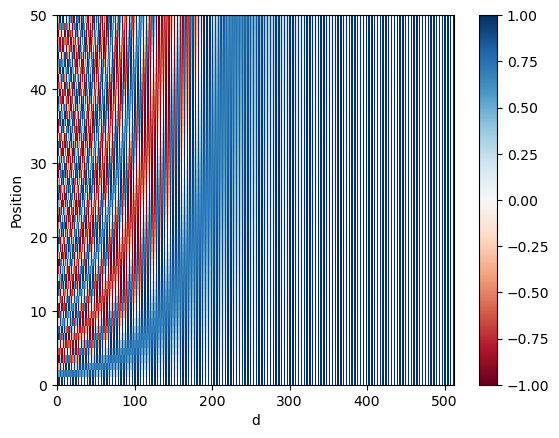

In [6]:
pos_encoding = positional_encoding(50, 512)

print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('d')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [7]:
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 100
MAX_NB_WORDS = 64
pos_encoding = positional_encoding(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM)

pos = 7
torch.norm(pos_encoding[0, pos, :]) # 每个pos的长度一样

k = 2 
torch.norm( pos_encoding[0, pos, :] - pos_encoding[0, pos+k, :] )

tensor(3.2669)

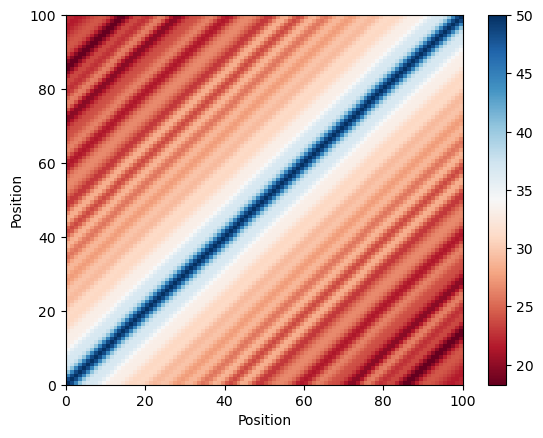

In [8]:
corr = torch.matmul(pos_encoding, pos_encoding.transpose(-1, -2)).numpy()[0]
plt.pcolormesh(corr, cmap='RdBu')
plt.xlabel('Position')
plt.xlim((0, 100))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [9]:
def create_padding_mask(seq):
    """
    Creates a matrix mask for the padding cells
    
    Arguments:
        seq -- (n, m) matrix
    
    Returns:
        mask -- (n, 1, 1, m) binary tensor
    """
     
    return (seq == 0).unsqueeze(1).unsqueeze(1).float()

In [10]:
x = torch.tensor([[7., 6., 0., 0., 1.], [1., 2., 3., 0., 0.], [0., 0., 0., 4., 5.]])
print(create_padding_mask(x))

tensor([[[[0., 0., 1., 1., 0.]]],


        [[[0., 0., 0., 1., 1.]]],


        [[[1., 1., 1., 0., 0.]]]])


In [11]:
print(torch.softmax(x, dim=-1))
print(torch.softmax(x + create_padding_mask(x) * -1.0e9, dim=-1))

tensor([[7.2877e-01, 2.6810e-01, 6.6455e-04, 6.6455e-04, 1.8064e-03],
        [8.4437e-02, 2.2952e-01, 6.2391e-01, 3.1063e-02, 3.1063e-02],
        [4.8541e-03, 4.8541e-03, 4.8541e-03, 2.6503e-01, 7.2041e-01]])
tensor([[[[7.2974e-01, 2.6845e-01, 0.0000e+00, 0.0000e+00, 1.8088e-03],
          [2.4473e-01, 6.6524e-01, 0.0000e+00, 0.0000e+00, 9.0031e-02],
          [6.6484e-03, 6.6484e-03, 0.0000e+00, 0.0000e+00, 9.8670e-01]]],


        [[[7.3057e-01, 2.6876e-01, 6.6620e-04, 0.0000e+00, 0.0000e+00],
          [9.0031e-02, 2.4473e-01, 6.6524e-01, 0.0000e+00, 0.0000e+00],
          [3.3333e-01, 3.3333e-01, 3.3333e-01, 0.0000e+00, 0.0000e+00]]],


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00, 2.6894e-01, 7.3106e-01],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 5.0000e-01, 5.0000e-01],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 2.6894e-01, 7.3106e-01]]]])


In [12]:
def create_look_ahead_mask(size):
    """
    Returns an upper triangular matrix filled with ones
    
    Arguments:
        size -- matrix size
    
    Returns:
        mask -- (size, size) tensor
    """
    mask = torch.triu(torch.ones((size, size)), diagonal=1).bool() 
    return mask 

In [13]:
x = torch.randn((1,3))
temp = create_look_ahead_mask(x.shape[1])
temp


tensor([[False,  True,  True],
        [False, False,  True],
        [False, False, False]])

In [14]:
import math 

def scaled_dot_product_attention(q, k, v, mask):
    """
    Calculate the attention weights.
      q, k, v must have matching leading dimensions.
      k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
      The mask has different shapes depending on its type(padding or look ahead) 
      but it must be broadcastable for addition.

    Arguments:
        q -- query shape == (..., seq_len_q, depth)
        k -- key shape == (..., seq_len_k, depth)
        v -- value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable 
              to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
        output -- attention_weights
    """
    seq_len_q, dq = q.shape[-2], q.shape[-1]
    seq_len_k, dk = k.shape[-2], k.shape[-1]
    seq_len_v, dv = v.shape[-2], v.shape[-1]
    assert(dq == dk)
    assert(seq_len_k == seq_len_v)

    attn_map = torch.matmul(q, k.transpose(-1,-2)) / math.sqrt(dk) 
    if mask is not None:
        attn_map += mask * -1e9
    attn_map = torch.softmax(attn_map, dim=-1) # (..., seq_len_q, seq_len_k/v)

    output = torch.matmul(attn_map, v)
    return output, attn_map

In [15]:
# UNIT TEST
def scaled_dot_product_attention_test(target):
    q = np.array([[1, 0, 1, 1], [0, 1, 1, 1], [1, 0, 0, 1]]).astype(np.float32)
    k = np.array([[1, 1, 0, 1], [1, 0, 1, 1 ], [0, 1, 1, 0], [0, 0, 0, 1]]).astype(np.float32)
    v = np.array([[0, 0], [1, 0], [1, 0], [1, 1]]).astype(np.float32)
    q = torch.from_numpy(q)
    k = torch.from_numpy(k)
    v = torch.from_numpy(v)


    attention, weights = target(q, k, v, None)
    assert torch.is_tensor(weights), "Weights must be a tensor"
    assert tuple(i for i in weights.shape) == (q.shape[0], k.shape[1]), f"Wrong shape. We expected ({q.shape[0]}, {k.shape[1]})"
    assert np.allclose(weights, [[0.2589478,  0.42693272, 0.15705977, 0.15705977],
                                   [0.2772748,  0.2772748,  0.2772748,  0.16817567],
                                   [0.33620113, 0.33620113, 0.12368149, 0.2039163 ]])

    assert torch.is_tensor(attention), "Output must be a tensor"
    assert tuple(i for i in attention.shape) == (q.shape[0], v.shape[1]), f"Wrong shape. We expected ({q.shape[0]}, {v.shape[1]})"
    assert np.allclose(attention, [[0.74105227, 0.15705977],
                                   [0.7227253,  0.16817567],
                                   [0.6637989,  0.2039163 ]])

    mask = np.array([[0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 0]], dtype=np.float32)
    attention, weights = target(q, k, v, mask)

    assert np.allclose(weights, [[0.30719590187072754, 0.5064803957939148, 0.0, 0.18632373213768005],
                                 [0.3836517333984375, 0.3836517333984375, 0.0, 0.2326965481042862],
                                 [0.3836517333984375, 0.3836517333984375, 0.0, 0.2326965481042862]]), "Wrong masked weights"
    assert np.allclose(attention, [[0.6928040981292725, 0.18632373213768005],
                                   [0.6163482666015625, 0.2326965481042862], 
                                   [0.6163482666015625, 0.2326965481042862]]), "Wrong masked attention"
    
    print("\033[92mAll tests passed")
    
scaled_dot_product_attention_test(scaled_dot_product_attention)

All tests passed


/var/folders/r5/mzx6l9q17g31sxd4tqcy7vlw0000gn/T/ipykernel_57329/3628550545.py:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  attn_map += mask * -1e9


In [16]:
class EncoderLayer(nn.Module):
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1, layernorm_eps=1e-6):
        super().__init__() 

        self.mha = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, batch_first=True)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.layernormal1 = nn.LayerNorm(normalized_shape=embedding_dim, eps=layernorm_eps)

        self.ffn = nn.Sequential(
            nn.Linear(embedding_dim, fully_connected_dim),
            nn.ReLU(), 
            nn.Linear(fully_connected_dim, embedding_dim)
        )
        self.dropout2 = nn.Dropout(dropout_rate)
        self.layernormal2 = nn.LayerNorm(normalized_shape=embedding_dim, eps=layernorm_eps)
    
    def forward(self, x, src_key_padding_mask):
        """
        Forward pass for the Encoder Layer
        
        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len, embedding_dim) 
            src_key_padding_mask -- (batch_size, input_seq_len) Boolean mask to ensure that the padding is not 
                    treated as part of the input
        Returns:
            out2 -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """
        self_attn_output, enc_wei = self.mha(x, x, x, key_padding_mask=src_key_padding_mask)  
        # print(enc_wei)
        self_attn_output = self.dropout1(self_attn_output)
        output1 = self.layernormal1(x+self_attn_output)

        ffn_output = self.ffn(output1) 
        ffn_output = self.dropout2(ffn_output)
        output2 = self.layernormal2(output1+ffn_output)

        return output2


In [17]:
q = np.array([[[1, 0, 1, 1], [0, 1, 1, 1], [1, 0, 0, 1]]]).astype(np.float32)
q = torch.from_numpy(q)
encoder_layer1 = EncoderLayer(4, 2, 8)
print(encoder_layer1)
# for name, para in encoder_layer1.named_parameters():
#     print(name, para.shape)

encoder_layer1.eval()
with torch.no_grad():
    encoded = encoder_layer1(q, None)  
    print(encoded) 

EncoderLayer(
  (mha): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
  )
  (dropout1): Dropout(p=0.1, inplace=False)
  (layernormal1): LayerNorm((4,), eps=1e-06, elementwise_affine=True)
  (ffn): Sequential(
    (0): Linear(in_features=4, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
  (dropout2): Dropout(p=0.1, inplace=False)
  (layernormal2): LayerNorm((4,), eps=1e-06, elementwise_affine=True)
)
tensor([[[ 0.3862, -1.7206,  0.6618,  0.6726],
         [-1.5792, -0.1308,  0.9710,  0.7390],
         [ 0.8391, -1.2567, -0.6938,  1.1114]]])


In [18]:
class Encoder(nn.Module):
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super().__init__() 
        self.embedding_dim = embedding_dim 
        self.num_layers = num_layers 

        # (batch_size, seq_len, embedding_dim)
        self.embedding = nn.Embedding(num_embeddings=input_vocab_size, embedding_dim=embedding_dim)
        # (1, seq_len, embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.embedding_dim) 

        self.enc_layers = nn.ModuleList([
            EncoderLayer(embedding_dim, num_heads, fully_connected_dim, dropout_rate, layernorm_eps) 
            for _ in range(num_layers)
        ])

        

    def forward(self, x, src_key_padding_mask):
        """
        Forward pass for the Encoder
        
        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len) 
            src_key_padding_mask -- (batch_size, input_seq_len) Boolean mask to ensure that the padding is not 
                    treated as part of the input
        Returns:
            out2 -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """
        seq_len = x.shape[1]
        x = self.embedding(x) 
        x *= math.sqrt(self.embedding_dim)
        x += self.pos_encoding[:,:seq_len,:]
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, src_key_padding_mask)
        return x 

In [19]:
q = np.array([[19, 17, 0], [18, 2, 0]]).astype(np.int64)
q_key_padding_mask = np.array([[0, 0, 1], [0, 0, 1]]).astype(bool)
q = torch.from_numpy(q)
q_key_padding_mask = torch.from_numpy(q_key_padding_mask) 
encoder = Encoder(6, 4, 2, 8, 20, 20)
print(encoder)
# for name, para in encoder.named_parameters():
#     print(name, para.shape)

encoder.eval()
with torch.no_grad():
    encoded = encoder(q, q_key_padding_mask) # attn_mask
    print(encoded.shape) 

Encoder(
  (embedding): Embedding(20, 4)
  (enc_layers): ModuleList(
    (0-5): 6 x EncoderLayer(
      (mha): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
      )
      (dropout1): Dropout(p=0.1, inplace=False)
      (layernormal1): LayerNorm((4,), eps=1e-06, elementwise_affine=True)
      (ffn): Sequential(
        (0): Linear(in_features=4, out_features=8, bias=True)
        (1): ReLU()
        (2): Linear(in_features=8, out_features=4, bias=True)
      )
      (dropout2): Dropout(p=0.1, inplace=False)
      (layernormal2): LayerNorm((4,), eps=1e-06, elementwise_affine=True)
    )
  )
)
torch.Size([2, 3, 4])


In [20]:
class DecoderLayer(nn.Module):
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1, layernorm_eps=1e-6):
        super().__init__() 
        self.mha1 = nn.MultiheadAttention(embedding_dim, num_heads, batch_first=True)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.layernorm1 = nn.LayerNorm(normalized_shape=embedding_dim, eps=layernorm_eps)

        self.mha2 = nn.MultiheadAttention(embedding_dim, num_heads, batch_first=True)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.layernorm2 = nn.LayerNorm(normalized_shape=embedding_dim, eps=layernorm_eps)

        self.ffn = nn.Sequential(
            nn.Linear(embedding_dim, fully_connected_dim), 
            nn.ReLU(),
            nn.Linear(fully_connected_dim, embedding_dim)
        )
        self.dropout3 = nn.Dropout(dropout_rate)
        self.layernorm3 = nn.LayerNorm(normalized_shape=embedding_dim, eps=layernorm_eps)

    def forward(self, x, enc_output, look_ahead_mask, src_key_padding_mask, tgt_key_padding_mask):
        """
        x: (batch_size, target_seq_len, embedding_dim)
        enc_output: (batch_size, input_seq_len, embedding_dim)
        look_ahead_mask -- Boolean mask for the target_input
        src_key_padding_mask -- Boolean mask for the second multihead attention layer
        tgt_key_padding_mask -- Boolean mask for the first multihead attention layer
        """
        mha_output1, mha_weight1 = self.mha1(x, x, x, key_padding_mask=tgt_key_padding_mask, attn_mask=look_ahead_mask)
        mha_output1 = self.dropout1(mha_output1)
        output1 = self.layernorm1(x+mha_output1)

        mha_output2, mha_weight2 = self.mha2(output1, enc_output, enc_output, key_padding_mask=src_key_padding_mask)
        mha_output2 = self.dropout2(mha_output2)
        output2 = self.layernorm2(output1+mha_output2)

        ffn_output = self.ffn(output2) 
        ffn_output = self.dropout3(ffn_output)
        output3 = self.layernorm3(output2+ffn_output)
        
        return output3, mha_weight1, mha_weight2

In [21]:
decoderLayer1 = DecoderLayer(embedding_dim=4, num_heads=2,fully_connected_dim=32)
print(decoderLayer1)
# for name, para in decoderLayer1.named_parameters():
#     print(name, para.shape)
decoderLayer1.eval()
with torch.no_grad():
    enc_output = torch.randn((1, 3, 4), dtype=torch.float32)
    q = torch.randn((1, 5, 4), dtype=torch.float32)
    look_ahead_mask = create_look_ahead_mask(5) 
    output, wei1, wei2 = decoderLayer1(q, enc_output, look_ahead_mask, None, None)
    print(output.shape)
    print(wei1)
    print(wei2)

DecoderLayer(
  (mha1): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
  )
  (dropout1): Dropout(p=0.1, inplace=False)
  (layernorm1): LayerNorm((4,), eps=1e-06, elementwise_affine=True)
  (mha2): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
  )
  (dropout2): Dropout(p=0.1, inplace=False)
  (layernorm2): LayerNorm((4,), eps=1e-06, elementwise_affine=True)
  (ffn): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=4, bias=True)
  )
  (dropout3): Dropout(p=0.1, inplace=False)
  (layernorm3): LayerNorm((4,), eps=1e-06, elementwise_affine=True)
)
torch.Size([1, 5, 4])
tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.5286, 0.4714, 0.0000, 0.0000, 0.0000],
         [0.3223, 0.3293, 0.3484, 0.0000, 0.0000],
         [0.2758, 0.2652, 0.2344, 0.2246, 0.0000],
         [0.238

In [22]:
class Decoder(nn.Module):
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, target_vocab_size,
                    maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super().__init__() 
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        self.pos_encoding = positional_encoding(maximum_position_encoding, embedding_dim)

        self.embedding = nn.Embedding(target_vocab_size, embedding_dim)
        
        self.dec_layers = nn.ModuleList([
            DecoderLayer(embedding_dim, num_heads, fully_connected_dim, dropout_rate, layernorm_eps)
            for _ in range(num_layers)
        ]) 

    def forward(self, x, enc_output, look_ahead_mask, src_key_padding_mask, tgt_key_padding_mask):
        """
        x -- Tensor of shape (batch_size, target_seq_len)
        enc_output --  Tensor of shape(batch_size, input_seq_len, embedding_dim) 
        look_ahead_mask -- Boolean mask for the target_input
        src_key_padding_mask tgt_key_padding_mask
        """
        target_seq_len = x.shape[1]
        attention_weights = {}
        x = self.embedding(x) 
        x *= math.sqrt(self.embedding_dim)
        x += self.pos_encoding[:,:target_seq_len,:]
        for i in range(self.num_layers):
            x, wei1, wei2 = self.dec_layers[i](x, enc_output, look_ahead_mask, src_key_padding_mask, tgt_key_padding_mask)
            attention_weights['decoder_layer{}_block1_self_att'.format(i+1)] = wei1
            attention_weights['decoder_layer{}_block2_decenc_att'.format(i+1)] = wei2

        return x, attention_weights

In [23]:
decoder = Decoder(num_layers=6, embedding_dim=4, num_heads=2, fully_connected_dim=32,
    target_vocab_size=33, maximum_position_encoding=8
)
print(decoder)
# for name, para in decoder.named_parameters():
#     print(name, para.shape)
decoder.eval()
with torch.no_grad():
    enc_output = torch.randn((1, 3, 4), dtype=torch.float32)
    q = np.array([[19, 1, 19, 10, 1]]).astype(np.int64)
    q = torch.from_numpy(q)
    look_ahead_mask = create_look_ahead_mask(5) 
    output, attention_weights = decoder(q, enc_output, look_ahead_mask, None, None)
    print(output.shape)
    print(attention_weights) 

Decoder(
  (embedding): Embedding(33, 4)
  (dec_layers): ModuleList(
    (0-5): 6 x DecoderLayer(
      (mha1): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
      )
      (dropout1): Dropout(p=0.1, inplace=False)
      (layernorm1): LayerNorm((4,), eps=1e-06, elementwise_affine=True)
      (mha2): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
      )
      (dropout2): Dropout(p=0.1, inplace=False)
      (layernorm2): LayerNorm((4,), eps=1e-06, elementwise_affine=True)
      (ffn): Sequential(
        (0): Linear(in_features=4, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=4, bias=True)
      )
      (dropout3): Dropout(p=0.1, inplace=False)
      (layernorm3): LayerNorm((4,), eps=1e-06, elementwise_affine=True)
    )
  )
)
torch.Size([1, 5, 4])
{'decoder_layer1_block1_self_att': tensor([[[1.0000, 0.00

In [24]:
class Transformer(nn.Module):
    """
    Complete transformer with an Encoder and a Decoder
    """
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, 
               target_vocab_size, max_positional_encoding_input,
               max_positional_encoding_target, dropout_rate=0.1, layernorm_eps=1e-6):
        super().__init__()

        self.encoder = Encoder(num_layers=num_layers,
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               input_vocab_size=input_vocab_size,
                               maximum_position_encoding=max_positional_encoding_input,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.decoder = Decoder(num_layers=num_layers, 
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               target_vocab_size=target_vocab_size, 
                               maximum_position_encoding=max_positional_encoding_target,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.final_layer = nn.Linear(embedding_dim, target_vocab_size)
    
    def forward(self, inp, tar, src_padding_mask, look_ahead_mask, tgt_padding_mask):
        """
        Forward pass for the entire Transformer
        Arguments:
            inp -- Tensor of shape (batch_size, input_seq_len, fully_connected_dim)
            tar -- Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            src_padding_mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
            look_ahead_mask -- Boolean mask for the target_input
            tgt_padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            final_output -- Describe me
            attention_weights - Dictionary of tensors containing all the attention weights for the decoder
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        
        """
        # call self.encoder with the appropriate arguments to get the encoder output
        enc_output = self.encoder(inp, src_padding_mask) # (batch_size, inp_seq_len, fully_connected_dim)
        
        # call self.decoder with the appropriate arguments to get the decoder output
        # dec_output.shape == (batch_size, tar_seq_len, fully_connected_dim)
        dec_output, attention_weights = self.decoder(tar, enc_output, look_ahead_mask, src_padding_mask, tgt_padding_mask)
        
        # pass decoder output through a linear layer and softmax (~2 lines)
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
        

        return final_output, attention_weights

In [25]:
num_layers = 6
embedding_dim = 4
num_heads = 4
fully_connected_dim = 8
input_vocab_size = 30
target_vocab_size = 35
max_positional_encoding_input = 5
max_positional_encoding_target = 6

trans = Transformer(num_layers, 
                    embedding_dim, 
                    num_heads, 
                    fully_connected_dim, 
                    input_vocab_size, 
                    target_vocab_size, 
                    max_positional_encoding_input,
                    max_positional_encoding_target)
# 0 is the padding value
sentence_lang_a = np.array([[2, 1, 4, 3, 0]]).astype(np.int64)
sentence_lang_a = torch.from_numpy(sentence_lang_a)
sentence_lang_b = np.array([[3, 2, 1, 0, 0]]).astype(np.int64)
sentence_lang_b = torch.from_numpy(sentence_lang_b)

src_key_padding_mask = np.array([[0, 0, 0, 0, 1]]).astype(bool)
src_key_padding_mask = torch.from_numpy(src_key_padding_mask)
look_ahead_mask = create_look_ahead_mask(sentence_lang_b.shape[1])
tar_key_padding_mask = np.array([[0, 0, 0, 1, 1]]).astype(bool)
tar_key_padding_mask = torch.from_numpy(tar_key_padding_mask)


translation, weights = trans(
    sentence_lang_a,
    sentence_lang_b, 
    src_key_padding_mask,
    look_ahead_mask,
    tar_key_padding_mask
)

In [26]:
translation.shape

torch.Size([1, 5, 35])

In [27]:
weights

{'decoder_layer1_block1_self_att': tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.7082, 0.2918, 0.0000, 0.0000, 0.0000],
          [0.1654, 0.4831, 0.3515, 0.0000, 0.0000],
          [0.3426, 0.2507, 0.4067, 0.0000, 0.0000],
          [0.3515, 0.2493, 0.3992, 0.0000, 0.0000]]], grad_fn=<MeanBackward1>),
 'decoder_layer1_block2_decenc_att': tensor([[[0.2200, 0.2320, 0.3274, 0.2206, 0.0000],
          [0.2645, 0.2351, 0.2099, 0.2905, 0.0000],
          [0.2675, 0.2516, 0.2029, 0.2780, 0.0000],
          [0.2731, 0.2575, 0.1985, 0.2709, 0.0000],
          [0.2620, 0.2579, 0.2189, 0.2611, 0.0000]]], grad_fn=<MeanBackward1>),
 'decoder_layer2_block1_self_att': tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.5452, 0.4548, 0.0000, 0.0000, 0.0000],
          [0.3546, 0.3439, 0.3015, 0.0000, 0.0000],
          [0.2634, 0.3865, 0.3500, 0.0000, 0.0000],
          [0.3247, 0.3474, 0.3279, 0.0000, 0.0000]]], grad_fn=<MeanBackward1>),
 'decoder_layer2_block2_decenc_a